# <a id='env'>1. Import Libraries</a>

In [11]:
!pip install imutils


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [12]:
import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    

from keras.models import Sequential
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D,Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model

import math
import seaborn as sns
import umap
from PIL import Image
from scipy import misc
from os.path import isfile, join
from scipy import misc
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from keras.utils.np_utils import to_categorical

from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

# <a id='import'>2. Data Import</a>

In [13]:
image_dir="../input/brain-mri-images-for-brain-tumor-detection/"

### Making directory for augmented images

In [14]:
# os.makedirs('../output/kaggle/working/augmented-images')
# os.makedirs('../output/kaggle/working/augmented-images/yes')
# os.makedirs('../output/kaggle/working/augmented-images/no')

In [15]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [16]:
augmented_data_path ='../output/kaggle/working/augmented-images/'
# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir=image_dir+'yes',n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=image_dir+'no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')

# <a id='env'>3. Preproccesnig </a>

In [17]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

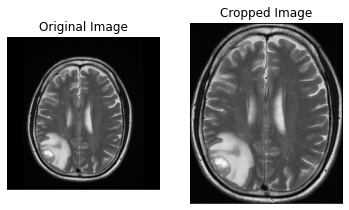

In [18]:
ex_img = cv2.imread(image_dir+'yes/Y107.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [19]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [20]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 4019
X shape is: (4019, 240, 240, 3)
y shape is: (4019, 1)


In [21]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

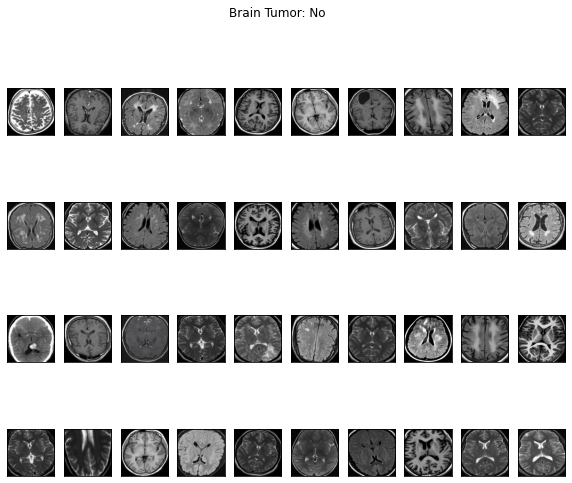

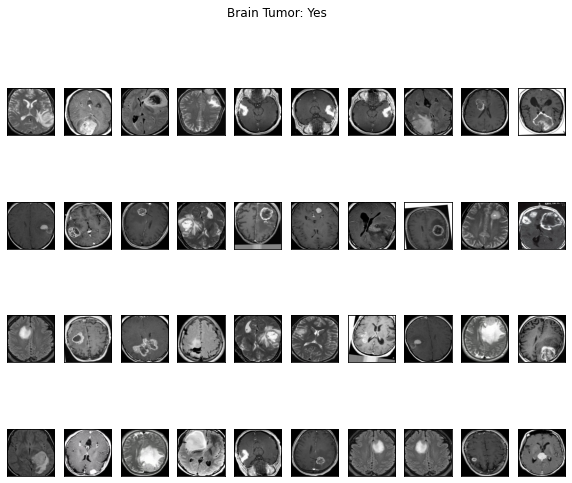

In [22]:
plot_sample_images(X, y)

# <a id='env'>4. Data Splitting</a>

In [23]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [24]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [25]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 2813
number of validation examples = 603
number of test examples = 603


# <a id='env'>5. First CNN Model </a>

In [26]:
def build_model(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((2, 2))(X_input)
    
    X = Conv2D(32, (7, 7), strides=(1, 1))(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((4, 4))(X)
    X = MaxPooling2D((4, 4))(X)
    
    X = Flatten()(X)
    X = Dense(128, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.5)(X)  # Use tf.keras.layers.Dropout instead of Dropout
    
    X = Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs=X_input, outputs=X)
    
    return model

In [27]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0     

In [28]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
88/88 [==============================] - 4s 43ms/step - loss: 0.8889 - accuracy: 0.6100 - val_loss: 0.6643 - val_accuracy: 0.5788
Epoch 2/50
88/88 [==============================] - 3s 38ms/step - loss: 0.6021 - accuracy: 0.6626 - val_loss: 0.6299 - val_accuracy: 0.7761
Epoch 3/50
88/88 [==============================] - 3s 38ms/step - loss: 0.5737 - accuracy: 0.6769 - val_loss: 0.5296 - val_accuracy: 0.7910
Epoch 4/50
88/88 [==============================] - 3s 38ms/step - loss: 0.5352 - accuracy: 0.7263 - val_loss: 0.4945 - val_accuracy: 0.7711
Epoch 5/50
88/88 [==============================] - 3s 38ms/step - loss: 0.4697 - accuracy: 0.7586 - val_loss: 0.4297 - val_accuracy: 0.7894
Epoch 6/50
88/88 [==============================] - 3s 38ms/step - loss: 0.4601 - accuracy: 0.7714 - val_loss: 0.4125 - val_accuracy: 0.7993
Epoch 7/50
88/88 [==============================] - 3s 38ms/step - loss: 0.4213 - accuracy: 0.7977 - val_loss: 0.3450 - val_accuracy: 0.8507
Epoch 8/50
88

In [29]:
history = model.history.history

In [30]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

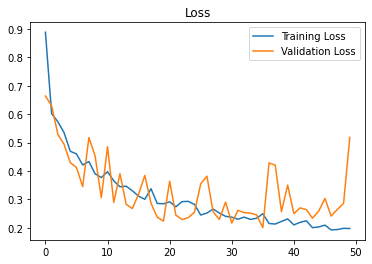

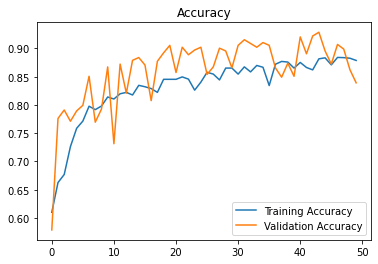

In [31]:
plot_metrics(history)

In [32]:
loss, accuracy = model.evaluate(X_test, y_test)

# Print the accuracy
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test loss: {loss * 100:.2f}%")

19/19 [==============================] - 0s 14ms/step - loss: 0.5026 - accuracy: 0.8292
Test Accuracy: 82.92%
Test loss: 50.26%


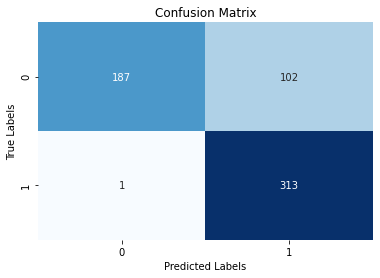

In [33]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# <a id='import'>6. Second CNN Model</a>

In [34]:
model2 = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model2.add(Conv2D(filters=16,kernel_size=9, padding='same', activation='relu', input_shape=(240,240,3))) 
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.45))

model2.add(Conv2D(filters=16,kernel_size=9,padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.25))

model2.add(Conv2D(filters=36, kernel_size=9, padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.25))

model2.add(Flatten())

model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.15))


model2.add(Dense(1, activation='sigmoid'))

# Take a look at the model summary
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 240, 240, 16)      3904      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 120, 120, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 120, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 120, 16)      20752     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 60, 60, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 36)        4

In [35]:
model2.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['acc'])

In [36]:
model2.fit(X_train,
           y_train,
         batch_size=128,
         epochs=50,
         validation_data=(X_val, y_val))

Epoch 1/50
22/22 [==============================] - 4s 175ms/step - loss: 2.0119 - acc: 0.4572 - val_loss: 0.6930 - val_acc: 0.5290
Epoch 2/50
22/22 [==============================] - 3s 132ms/step - loss: 0.6928 - acc: 0.5464 - val_loss: 0.6927 - val_acc: 0.5290
Epoch 3/50
22/22 [==============================] - 3s 138ms/step - loss: 0.6920 - acc: 0.5464 - val_loss: 0.6923 - val_acc: 0.5290
Epoch 4/50
22/22 [==============================] - 3s 133ms/step - loss: 0.6912 - acc: 0.5464 - val_loss: 0.6918 - val_acc: 0.5290
Epoch 5/50
22/22 [==============================] - 3s 136ms/step - loss: 0.6889 - acc: 0.5464 - val_loss: 0.6873 - val_acc: 0.5290
Epoch 6/50
22/22 [==============================] - 3s 135ms/step - loss: 0.6838 - acc: 0.5464 - val_loss: 0.6844 - val_acc: 0.5290
Epoch 7/50
22/22 [==============================] - 3s 133ms/step - loss: 0.6803 - acc: 0.5464 - val_loss: 0.6813 - val_acc: 0.5290
Epoch 8/50
22/22 [==============================] - 3s 134ms/step - loss: 0.

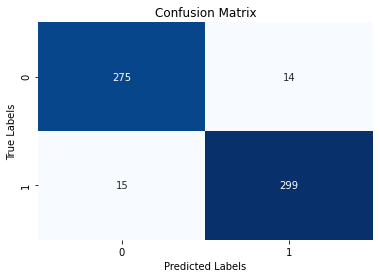

In [37]:
y_pred = model2.predict(X_test)
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [39]:
score = model2.evaluate(X_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])
print('\n', 'Test loss:', score[0])


 Test accuracy: 0.9519071578979492

 Test loss: 0.1744253784418106


# <a id='import'>7. Transfer Learning Model By VGG-16</a>

In [40]:
# load base model
vgg16_weight_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg16_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SHAPE
)

In [41]:

model = Sequential()
model.add(vgg16_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [42]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val)) #22

Train on 2813 samples, validate on 603 samples
Epoch 1/22
2813/2813 [==============================] - 14s 5ms/step - loss: 0.4300 - accuracy: 0.7999 - val_loss: 0.2550 - val_accuracy: 0.9071
Epoch 2/22
2813/2813 [==============================] - 11s 4ms/step - loss: 0.1980 - accuracy: 0.9289 - val_loss: 0.1708 - val_accuracy: 0.9436
Epoch 3/22
2813/2813 [==============================] - 11s 4ms/step - loss: 0.1353 - accuracy: 0.9584 - val_loss: 0.1070 - val_accuracy: 0.9801
Epoch 4/22
2813/2813 [==============================] - 11s 4ms/step - loss: 0.0961 - accuracy: 0.9762 - val_loss: 0.0875 - val_accuracy: 0.9834
Epoch 5/22
2813/2813 [==============================] - 11s 4ms/step - loss: 0.0757 - accuracy: 0.9833 - val_loss: 0.0759 - val_accuracy: 0.9884
Epoch 6/22
2813/2813 [==============================] - 11s 4ms/step - loss: 0.0636 - accuracy: 0.9897 - val_loss: 0.0698 - val_accuracy: 0.9851
Epoch 7/22
2813/2813 [==============================] - 11s 4ms/step - loss: 0.0497

In [43]:
history = model.history.history


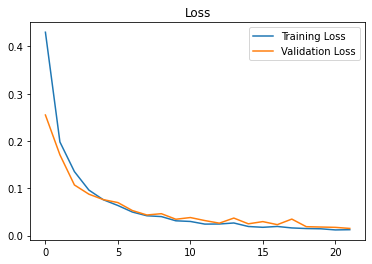

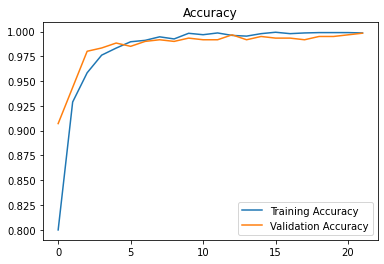

In [44]:
plot_metrics(history)

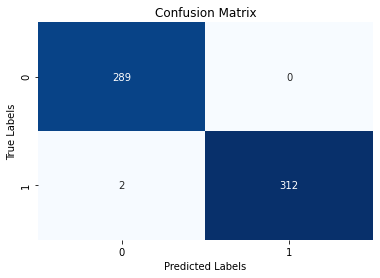

In [45]:
y_pred = model.predict(X_test)
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [46]:
score = model.evaluate(X_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])
print('\n', 'Test loss:', score[0])


 Test accuracy: 0.9966832399368286

 Test loss: 0.01508733297807858
